In [50]:
import pandas as pd
from tqdm import tqdm
import os
import librosa as lb
import seaborn as sns
import numpy as np
from glob import glob
import shutil
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
#import splitfolders
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import audioSegmentation as aS
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, Input, MaxPooling1D, Activation, Permute, Dense, BatchNormalization, Flatten, LSTM, Bidirectional, Dropout, Masking, TimeDistributed

In [2]:
file_data = pd.read_csv('file_data.csv')

In [3]:
file_data

,fname,start,end,crack_wheez,fname_cycle,len
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,101_1b1_Al_sc_Meditron_0.wav,0.543
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,101_1b1_Al_sc_Meditron_1.wav,1.871
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,101_1b1_Al_sc_Meditron_2.wav,1.443
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,101_1b1_Al_sc_Meditron_3.wav,1.900
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,101_1b1_Al_sc_Meditron_4.wav,1.728
...,...,...,...,...,...,...
6733,226_1b1_Pl_sc_LittC2SE,11.721,13.693,1,226_1b1_Pl_sc_LittC2SE_6.wav,1.972
6734,226_1b1_Pl_sc_LittC2SE,13.693,15.536,0,226_1b1_Pl_sc_LittC2SE_7.wav,1.843
6735,226_1b1_Pl_sc_LittC2SE,15.536,17.493,0,226_1b1_Pl_sc_LittC2SE_8.wav,1.957
6736,226_1b1_Pl_sc_LittC2SE,17.493,19.436,1,226_1b1_Pl_sc_LittC2SE_9.wav,1.943


In [31]:
#define LSTM model with skip connection
def LSTM():
    N_CLASSES=4

    i = layers.Input(shape=(20, 79), name='input')
    x = layers.Masking()(i)
    x = layers.BatchNormalization(name='batch_norm')(x)
    x = layers.Permute((2,1), name='permute')(x)
    s = TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh')(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True),
                             name='bidirectional_lstm')(s)
    x = layers.concatenate([s, x], axis=2, name='skip_connection')
    x = layers.Dense(64, activation='relu', name='dense_1_relu')(x)
    x = layers.MaxPooling1D(name='max_pool_1d')(x)
    x = layers.Dense(32, activation='relu', name='dense_2_relu')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.5, name='dropout')(x)
    x = layers.Dense(32, activation='relu',
                         activity_regularizer=regularizers.l2(0.001),
                         name='dense_3_relu')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)

    model = Model(inputs=i, outputs=o, name='long_short_term_memory')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [32]:
LSTM().summary()

Model: "long_short_term_memory"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 20, 79)]     0                                            
__________________________________________________________________________________________________
masking_4 (Masking)             (None, 20, 79)       0           input[0][0]                      
__________________________________________________________________________________________________
batch_norm (BatchNormalization) (None, 20, 79)       316         masking_4[0][0]                  
__________________________________________________________________________________________________
permute (Permute)               (None, 79, 20)       0           batch_norm[0][0]                 
_____________________________________________________________________________

In [33]:
# Split data into train and test sets
train_df, test_df = train_test_split(file_data, test_size=0.2, random_state=0)

In [34]:
train_df

,fname,start,end,crack_wheez,fname_cycle,len
3943,172_1b3_Pr_mc_AKGC417L,17.571,19.975,1,172_1b3_Pr_mc_AKGC417L_6.wav,2.404
2632,152_1b1_Al_sc_Meditron,11.279,14.507,0,152_1b1_Al_sc_Meditron_4.wav,3.228
828,120_1b1_Pr_sc_Meditron,53.735,57.214,0,120_1b1_Pr_sc_Meditron_17.wav,3.479
1371,130_2p5_Tc_mc_AKGC417L,15.978,17.937,1,130_2p5_Tc_mc_AKGC417L_8.wav,1.959
3051,158_1b3_Ar_mc_LittC2SE,12.364,15.021,1,158_1b3_Ar_mc_LittC2SE_7.wav,2.657
...,...,...,...,...,...,...
4931,188_1b1_Ar_sc_Meditron,16.421,17.607,0,188_1b1_Ar_sc_Meditron_14.wav,1.186
3264,159_1b1_Al_sc_Meditron,4.693,6.493,0,159_1b1_Al_sc_Meditron_3.wav,1.800
1653,133_3p2_Ar_mc_AKGC417L,0.851,2.197,0,133_3p2_Ar_mc_AKGC417L_0.wav,1.346
2607,151_3p2_Pl_mc_AKGC417L,10.860,14.232,1,151_3p2_Pl_mc_AKGC417L_3.wav,3.372


In [35]:
#Reset index
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [36]:
#Set maxpad length as 79 <--(Sampling rate*5s)/256(hop length)
def build_feat(df):
    X = []
    Y = []
    max_pad_len = 79
    for i in tqdm(range(len(df))):
        file = df.iloc[i].fname_cycle
        label = df.iloc[i].crack_wheez
        wav,  rate = lb.load('Breath_cycles/'+ file, sr=None)
        #limit the length of samples to only 6s (6*4000)
        if wav.shape[0] > 20000:
            wav = wav[0:20000]
        X_sample = lb.feature.mfcc(wav, sr=rate, n_fft=512,  win_length=400, n_mfcc=20, hop_length = 256, n_mels = 128, fmin = 100, fmax = 1800)
        pad_width = max_pad_len - X_sample.shape[1]
        X_sample = np.pad(X_sample, pad_width=((0, 0), (0, pad_width)), mode='constant')
        X.append(X_sample)
        Y.append(label)
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [37]:
#Extract features for training data
X_, y_ = build_feat(train_df)

100%|██████████| 5390/5390 [01:09<00:00, 77.61it/s]


In [38]:
X_.shape

(5390, 20, 79)

In [12]:
#Extract feature for testing data
X_val, y_val = build_feat(test_df)

100%|██████████| 1348/1348 [00:08<00:00, 162.61it/s]


In [13]:
#Convert labels into one hot vectors
y_tr_cat= to_categorical(y_, num_classes=4)
y_val_cat= to_categorical(y_val, num_classes=4)

In [14]:
#Compute class weight for handling unbalanced classes
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
class_weight = compute_class_weight('balanced', np.unique(y_), y_)

/home/014544907/anaconda3/envs/master_project/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=[1 0 0 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [15]:
class_weight

array([0.47868561, 0.9001336 , 1.9962963 , 3.34367246])

In [22]:
class_weight = {0: class_weight[0], 1: class_weight[1], 2: class_weight[2], 3: class_weight[3]}

In [39]:
csv_path = os.path.join('logs', 'log_history_5s.csv')
model = LSTM()
#Save model checkpoints
cp = ModelCheckpoint('models/lstm_5s.h5', monitor='val_accuracy',  save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
csv_logger = CSVLogger(csv_path, append=False)


In [40]:
#Fit model
model.fit(X_,y_tr_cat, epochs = 100, workers=4, batch_size = 64, validation_data=(X_val, y_val_cat), callbacks=[csv_logger, cp], verbose = True)


Epoch 1/100
85/85 [==============================] - ETA: 0s - loss: 1.1537 - accuracy: 0.5139
Epoch 00001: val_accuracy improved from -inf to 0.52151, saving model to models/lstm_5s.h5
85/85 [==============================] - 46s 539ms/step - loss: 1.1537 - accuracy: 0.5139 - val_loss: 1.1418 - val_accuracy: 0.5215
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 1.1089 - accuracy: 0.5323
Epoch 00002: val_accuracy improved from 0.52151 to 0.52374, saving model to models/lstm_5s.h5
85/85 [==============================] - 43s 510ms/step - loss: 1.1089 - accuracy: 0.5323 - val_loss: 1.1130 - val_accuracy: 0.5237
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 1.0854 - accuracy: 0.5417
Epoch 00003: val_accuracy improved from 0.52374 to 0.54303, saving model to models/lstm_5s.h5
85/85 [==============================] - 41s 480ms/step - loss: 1.0854 - accuracy: 0.5417 - val_loss: 1.0723 - val_accuracy: 0.5430
Epoch 4/100
85/85 [=====================

In [45]:
# It can be used to reconstruct the model identically.
saved_model = keras.models.load_model("models/lstm_5s.h5")

                precision    recall  f1-score   support

          None       0.79      0.84      0.82       702
       Crackle       0.67      0.70      0.68       350
        Wheeze       0.70      0.52      0.60       199
Crackle_wheeze       0.52      0.47      0.50        97

      accuracy                           0.73      1348
     macro avg       0.67      0.63      0.65      1348
  weighted avg       0.73      0.73      0.73      1348



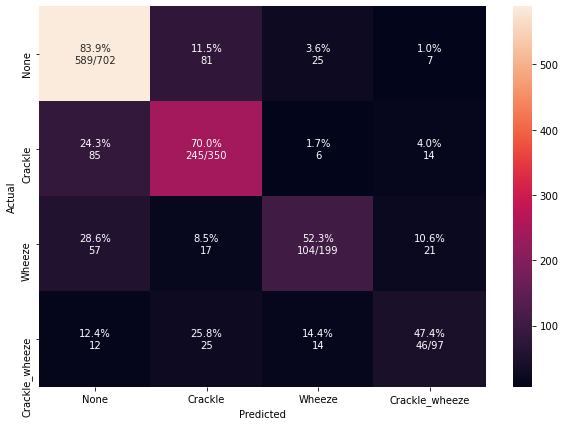

In [46]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["None", "Crackle", "Wheeze", "Crackle_wheeze"]

preds = saved_model.predict(X_val)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_val_cat, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')

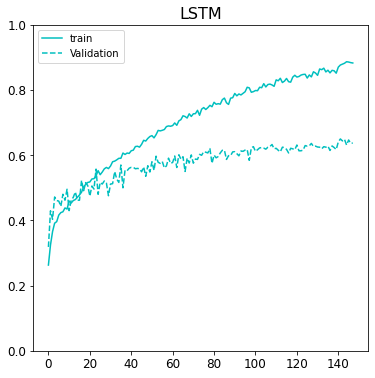

In [47]:
plt.figure(figsize=(6,6))
df = pd.read_csv('logs/log_history_3s.csv')
plt.title('LSTM', size=16)
plt.plot(df.accuracy, color='c', label='train')
plt.plot(df.val_accuracy, ls='--', color='c', label='Validation')
plt.legend(loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0,1.0])


plt.show()

In [51]:
[Fs, x] = aIO.read_audio_file("audio_and_txt_files/101_1b1_Al_sc_Meditron.wav")


In [55]:
Fs

44100

In [53]:
file_data[file_data.fname == '101_1b1_Al_sc_Meditron']

,fname,start,end,crack_wheez,fname_cycle,len
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,101_1b1_Al_sc_Meditron_0.wav,0.543
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,101_1b1_Al_sc_Meditron_1.wav,1.871
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,101_1b1_Al_sc_Meditron_2.wav,1.443
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,101_1b1_Al_sc_Meditron_3.wav,1.900
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,101_1b1_Al_sc_Meditron_4.wav,1.728
5,101_1b1_Al_sc_Meditron,7.521,9.279,0,101_1b1_Al_sc_Meditron_5.wav,1.758
6,101_1b1_Al_sc_Meditron,9.279,11.150,0,101_1b1_Al_sc_Meditron_6.wav,1.871
7,101_1b1_Al_sc_Meditron,11.150,13.036,0,101_1b1_Al_sc_Meditron_7.wav,1.886
8,101_1b1_Al_sc_Meditron,13.036,14.721,0,101_1b1_Al_sc_Meditron_8.wav,1.685
9,101_1b1_Al_sc_Meditron,14.721,16.707,0,101_1b1_Al_sc_Meditron_9.wav,1.986


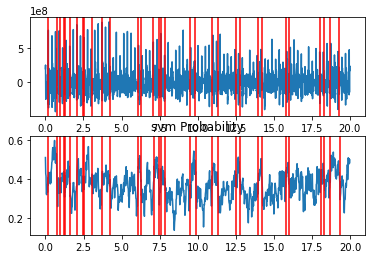

In [76]:
segments = aS.silence_removal(x, Fs, 0.02, 0.02, smooth_window = 0.2, weight = 0.5, plot = True)

In [77]:
segments

[[0.16, 0.76],
 [0.96, 1.22],
 [1.28, 1.6],
 [2.08, 2.46],
 [2.52, 3.08],
 [3.72, 4.24],
 [6.08, 6.28],
 [7.1000000000000005, 7.44],
 [7.6000000000000005, 7.86],
 [9.52, 9.86],
 [10.94, 11.32],
 [12.5, 12.780000000000001],
 [13.98, 14.22],
 [15.8, 16.02],
 [18.06, 18.32],
 [18.68, 19.32]]